# Fraud Detection 


### This project features machine learning techniques to predict whether or not a transaction is fraud.  

### The main objective of the project is analyzing a large dataset and obtain an appropriately fitted model using several approaches. 

##### Dataset used: E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016
##### Link: https://www.kaggle.com/ntnu-testimon/paysim1/data#fraud

##  1. Dataset exploration and transformation

The first thing is opening the dataset and exploring it to see its contents

In [2]:
import pandas as pd
df = pd.read_csv('financialfraud.csv', compression='zip')
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [ ]:
#df.shape
#df.dtypes
#df.isna().sum()
#df.type.value_counts()
#df.nameOrig.nunique()
#df.nameDest.nunique()

In [3]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

As it can be noticed, it is a very unbalanced dataset. Therefore, before balancing the data it is necessary to do some dataprep: Label encoding and evenly separating the dataset between train and test. 

There are three object type columns. The first one is type, which can be easily encoded using label encoder; the other two are nameOrig and nameDest. Since there are over 6 million entries, We need to try to understand the actual fraudulent transactions. According to the description of the dataset: 

isFraud - Refers to the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers' accounts and try to empty the funds by transferring to another account and then cashing out of the system.

In [4]:
from sklearn.preprocessing import LabelEncoder

labelencoder= LabelEncoder()
df[['type']] = df[['type']].apply(lambda x: labelencoder.fit_transform(x)).astype(np.int64)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,1,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,4,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,1,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,4,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
fraud = df.query('isFraud== 1')
legitimate = df.query('isFraud== 0')
X_fraud = fraud.drop(columns=['nameOrig','nameDest','isFraud'], axis=1)
y_fraud = fraud.isFraud
X_legitimate = legitimate.drop(columns=['nameOrig','nameDest','isFraud'], axis=1)
y_legitimate = legitimate.isFraud

The next procedure is splitting the data to create new datasets for training and testing. 

In [6]:
from sklearn.model_selection import train_test_split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=0)
X_legitimate_train, X_legitimate_test, y_legitimate_train, y_legitimate_test = train_test_split(X_legitimate, y_legitimate, test_size=0.2, random_state=0)
X_train = pd.concat([X_fraud_train,X_legitimate_train], axis=0)
y_train = pd.concat([y_fraud_train,y_legitimate_train], axis=0)
X_test = pd.concat([X_fraud_test,X_legitimate_test], axis=0)
y_test = pd.concat([y_fraud_test,y_legitimate_test], axis=0)
df_train = pd.concat([X_train,y_train], axis=1)
df_test = pd.concat([X_test,y_test], axis=1)

## 2. Dataset Balancing

In order to train a model with this characteristics, it is mandatory balancing the dataset.

In [7]:
from sklearn.utils import resample

legit = df_train[df_train.isFraud==0]
fraud = df_train[df_train.isFraud==1]

oversampled_fraud = resample(fraud, replace=True, n_samples=len(legit), random_state=0)
oversampled = pd.concat([legit, oversampled_fraud])
oversampled.isFraud.value_counts()

1    5083525
0    5083525
Name: isFraud, dtype: int64

In [8]:
X = oversampled.drop('isFraud', axis=1)
y = oversampled.isFraud

## 3. Modeling and Testing

Finally, it is possible to train and test some models. However, in order to set an appropriate logistic regression model it is recommended to use regularization. "*Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. The larger λ is the less likely it is that the parameters will be increased in magnitude simply to adjust for small perturbations in the data. In your case however, rather than specifying λ, you specify C=1/λ.*"  

Reference: https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, learning_curve

logistic = LogisticRegression(C=0.1, n_jobs=-1) 
pipeline = Pipeline(steps=[('dataprep', StandardScaler()),
                           ('logistic', logistic), 
                          ])

pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('dataprep',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [12]:
cross_val_score(pipeline, X, y, scoring='roc_auc', cv=KFold(n_splits=10, shuffle=True))

array([0.98149214, 0.98131671, 0.98123203, 0.98154043, 0.98129427,
       0.98123222, 0.98143173, 0.98139048, 0.98139719, 0.98136356])

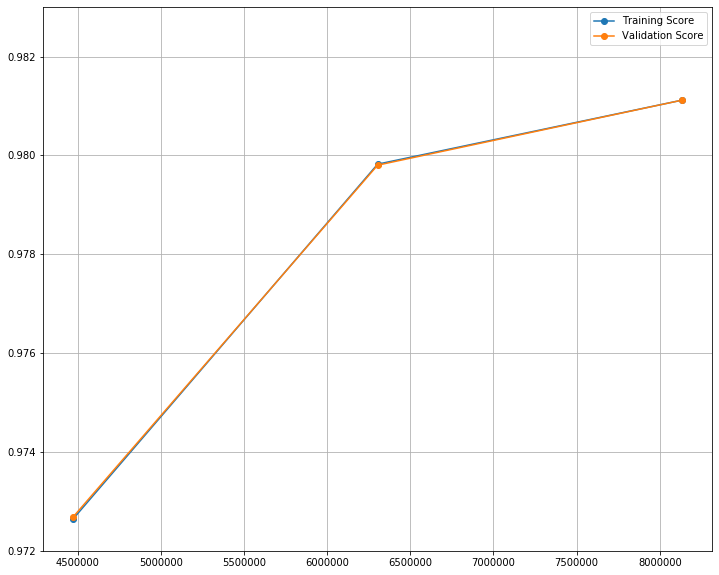

In [34]:
curves = learning_curve(pipeline, X, y, scoring='roc_auc', n_jobs=-1)

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

fig, ax = plt.subplots(figsize=(12,10))
plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.972, 0.983])
plt.legend()
plt.grid()

The learning curve shows that the model learned and stabilized at around 0.981 which was also demonstrated through the cross validation score.  

With this result, it is possible to test the data to see how the model fits.

In [14]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.9806922569873625

Then, the next step is doing the confusion matrix to test precision and recall.

In [16]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
confusion_matrix(y_test, pipeline.predict(X_test))

array([[1233535,   37347],
       [    180,    1463]], dtype=int64)

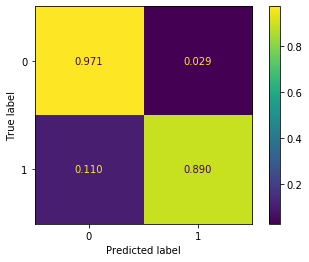

In [18]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='.3f', normalize='true')

These results shows that the model was able to predict 89% of the cases where there was fraud. The downside was a hit rate of over 3%, which, for this case, means that over 37000 entries were predicted as false positives.

In [38]:
from sklearn.metrics import precision_score, recall_score

print(f'According to the results, by using a logistic regression, the hit rate of the model was: {round(precision_score(y_test, pipeline.predict(X_test)),3)*100}%.\nAlso, the capture rate of the model was: {round(recall_score(y_test, pipeline.predict(X_test)),3)*100}%.')


According to the results, by using a plain logistic regression, the hit rate of the model was: 3.8%.
Also, the capture rate of the model was: 89.0%.


Another tool to understand the model is plotting a roc_curve.

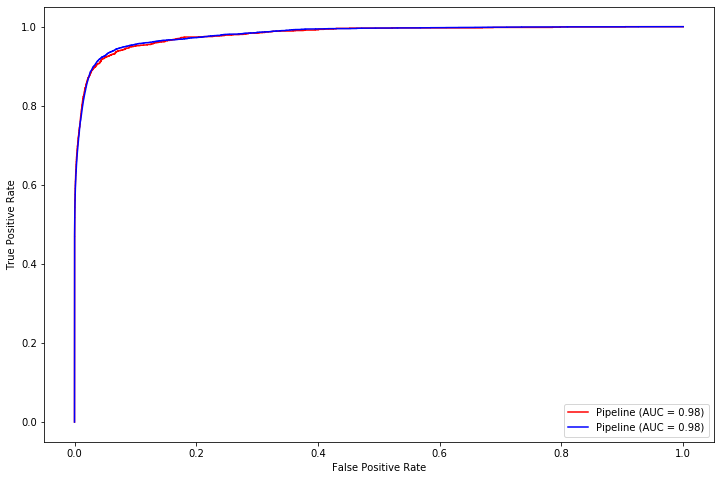

In [31]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
plot_roc_curve(pipeline, X_test, y_test, color='red', ax= ax)
plot_roc_curve(pipeline, X, y, color='blue', ax=ax)

A final step to see how changing the threshold affects precision and recall, an interactive library called ipywidgets is used.

The idea is visualizing true positive and false positive rates as the threshold parameters are changed.

In [41]:
from ipywidgets import interact, widgets

def safe_div(a, b):
    """
    This function avoids Zero Division error.
    """
    return a/b if b !=0 else 0

def get_roc_stats(thresh):
    fig, ax = plt.subplots(1, 1)
    
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    y_predicted = y_prob > thresh
    
    m = confusion_matrix(y_test, y_predicted)
    
    tpr = safe_div(m[1,1], (m[1,1] + m[1,0]))
    fpr = safe_div(m[0,1], (m[0,1] + m[1,1]))
    
    ax.scatter(fpr, tpr, c='red')
    ax.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), c='red')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    return tpr, fpr

order = 1e-2
slider = widgets.FloatSlider(min=-0.05, max =1.05, step= 0.05*order, value = 2.*order)

interact(get_roc_stats, thresh=slider)


interactive(children=(FloatSlider(value=0.02, description='thresh', max=1.05, min=-0.05, step=0.0005), Output(…

<function __main__.get_roc_stats(thresh)>

In [15]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

In [10]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X, y)
pd.DataFrame(zip(tree.feature_importances_, X.columns), columns=['importance','variable']).sort_values(by='importance')

,importance,variable
5,0.000000,oldbalanceDest
6,0.000000,newbalanceDest
7,0.000000,isFlaggedFraud
1,0.022956,type
0,0.048564,step
2,0.067405,amount
3,0.401902,oldbalanceOrg
4,0.459173,newbalanceOrig


According to the decision tree, the most important feature is newbalanceOrig, followed by oldbalanceOrg and amount. step and type of transaction show some relevance too. Now, it is necessary to analize the score of the model when using a 3 branch deep decision tree.

In [12]:
results = cross_val_score(tree, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.9679008546357816, 0.0001948371466706739)

### The ROC score by using a decision tree is nearly 2% lower than the score obtained using a logistic regression without mentioning that a decision tree tends to overfit a model.The next step would be training the model with random forests, stacking techniques, or even boosting to see if the ROC score improves. However, Due to the computational cost of using more complex models on this large dataset, the best fit for this particular project (Considering the hardware being used) is a logistic regression. 